[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/6_nb_model_assessment.ipynb) 


# Chapter 6 - Prediction model evaluation 
We have learned about logistic regression and CART in the previous chapter. Equipped with this knowledge, we can move on with revisiting practices to evaluate supervised learning models. Today, we focus on the assessment of predictive accuracy. Remember that accuracy is not the only relevant dimension of model performance. Also remember that both logit and CART could also be employed for *explanatory* modeling, which would imply use of yet different evaluation criteria. Here, however, our focus is prediction. Further, we will focus on models for classification. Measuring the predictive accuracy of a regression model is straightforward and involves calculating indicators such as MSE, MAE, MAPE, and the like. Once you can assess a classification model, you will have no problems whatsoever to assess a regression model.  

The outline of the tutorial is as follows:
- Preliminaries
- Forecast accuracy in classification
- Data partitioning and organization

# Preliminaries
As usual, it makes sense to import a set of standard libraries before moving on. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

## Data
Also as usual, we need some data to play with. Given our focus on classification and given that we know the data quite well by now, we will continue with the **HMEQ data set**. So let's load this data set as well, whereby we make use of the prepared version from [Tutorial 4](https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb), which is readily available in our [GitHub repo](https://github.com/Humboldt-WI/bads). Just return to [Tutorial 4](https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb) if you need a refresher.

In [3]:
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df = pd.read_csv(data_url, index_col="index")
df.head(5) 

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


In [8]:
df['BAD'] = df['BAD'].astype(int)  # zero-one encoding of the target

## Prediction models
Finally, since we aim at assessing predictions, we need to obtain some predictions in the first place. Let's quickly build a logit and a tree model for our data. 

In [13]:
# Split data into target and features
X = df.drop(['BAD'], axis=1) #code the variables in the most standard way for your usage
y = df['BAD']

In [14]:
# Estimate a logit model
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none', fit_intercept=True)
logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
# Estimate a CART tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Forecast accuracy in classification

## Continuous and discrete predictions
To generate prediction from a trained model, we simply apply it to data. You already saw the `predict()` function in action in [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorials/5_nb_supervised_learning.ipynb). At this point, however, it is time to examine its results more closely.

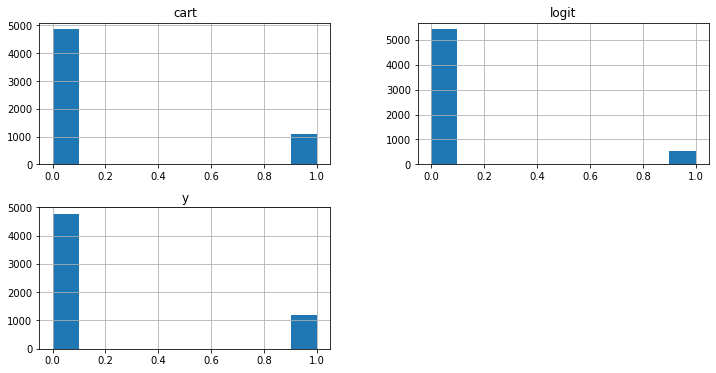

In [16]:
# We collect predictions into a dataframe for easy visualization
df_pred = pd.DataFrame({'y': y, 'cart': tree.predict(X), 'logit': logit.predict(X)})  
df_pred.hist();

How to interpret these graphs? Well, many points are maybe noteworthy:
- the data is imbalanced, $y$ shows more ones (bad clients) than zeros (good clients).
- CART and logit pick-up the imbalance and predict class 0 more often.
- CART and logit indeed predict classes, all predictions are either zero or one, and never anything in between.

Given the latter point, let's create some probabilistic predictions using the function `predict_proba()`. Remember that `sklearn` models routinely offer both functions, `predict()` and `predict_proba()`, for producing discrete and probabilistic predictions, respectively.

In [18]:
# Add probabilistic predictions to our dataframe
p = logit.predict_proba(X)
print(p)  # this is a 2D array

[[0.68156773 0.31843227]
 [0.28383127 0.71616873]
 [0.72952638 0.27047362]
 ...
 [0.94108985 0.05891015]
 [0.94531214 0.05468786]
 [0.94664408 0.05335592]]


When storing model predictions for later use, we only need the probabilities for one of the classes. Always make sure you **understand which class predictions you keep.**. Examining the `classess` attribute of a model class helps us.   

In [19]:
print(logit.classes_)

[0 1]


This says that we have two classes with class labels zero and one, respectively. Thus, to extract the estimated probabilities of the class with label zero, we can call `p[:,0]`. Likewise, `p[:,1]` gives the estimated membership probabilities of the second class with the label one. This is a bit complicated in the beginning but we have to get used to it. Below, we combine the indexing directly with calling `predict_proba()`, which is common practice, and keep the predictions associated with the second class. In our data, the class label one indicates that a borrower was a bad risk.

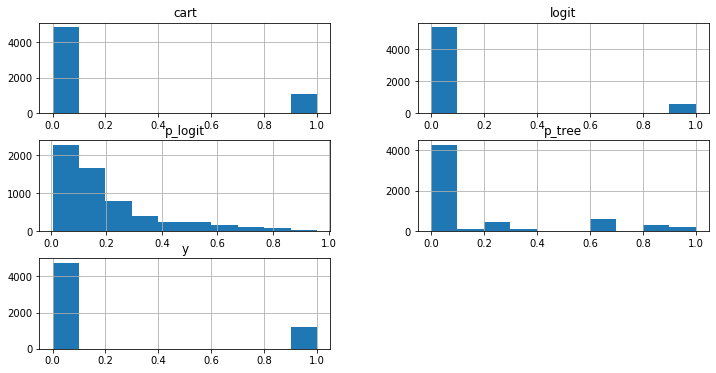

In [20]:
# Augment data frame with predictions
df_pred["p_logit"] = p[:,1]
df_pred["p_tree"] = tree.predict_proba(X)[:,1]
df_pred.hist();

## Measures of predictive accuracy 
Accuracy indicators help us evaluate how well our model predicts the target. We compute them by **comparing actuals to predictions**. One easy way to do so is by using the `score()` function.

In [21]:
print('Logit model scores {:.4}'.format(logit.score(X, y)))
print('Tree model scores {:.4}'.format(tree.score(X, y)))

Logit model scores 0.8245
Tree model scores 0.8908


Wow, so easy. Really? What actually is that score? Are higher scores better or should the score be low? We call functions like `score()` convenience functions. They are easy to use but hide many - often important - details. Look into the help to see what `score()` is really computing. 

We just asked you to look into the help. Don't be ignorant. Go back to the help before reading on. Pause.

In [22]:
import time
time.sleep(5)

Ok, **after reading the help** you now know that `score()` calculates *classification accuracy*. We defined that measure in the lecture. Let's first revisit the calculation

In [23]:
# Re-calc accuracy of logit
acc = np.sum(logit.predict(X)==y) / len(y)  # just one way to do the calculation
print("Manually calculated accuracy: {:.4}".format(acc))

Manually calculated accuracy: 0.8245


Ok that worked out. Now remember that we were rather critical with classification accuracy in the lecture. Let's revisit why we do not like this measure.

Classification accuracy is a **threshold metric**. It calculates model performance for one threshold or classification cut-off. If not specified, this threshold is usually set to 0.5. That's also what the `predict()` function does. Changing the threshold can change the accuracy a lot although the model stays the same. This is particularly true in imbalanced data sets like this one. Let me give you an exemplary scenario: We have 100 observations. 5 observations are of the class 'BAD' and 95 of the class 'GOOD'. So even without finding any generalizable patterns, classifying all observations as good would still result in an accuracy of 95%. To ensure robustness of our model, we want to avoid dependence of a performance measure on the cut-off.

A preferable approach to assess classification performance is to consider all possible thresholds. This is what *receiver-operating-characteristics (ROC) analysis* does. Before looking into ROC, let's have a look at the full confusion table first, which will also remind us of the role of the threshold.

### Confusion matrix
A confusion matrix is a cross-table of predicted and actual classes. As such, it provides more insight into a classifier compared to the classification accuracy measure, which summarizes the whole confusion table in a single number.

In [24]:
from sklearn import metrics  # Important lib where we find various performance measures

# 1. Quick and dirty way to get a confusion table
cmat = metrics.confusion_matrix(y, logit.predict(X)) 
print(cmat)

[[4568  203]
 [ 843  346]]


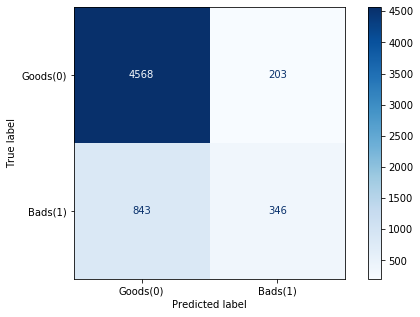

In [25]:
# 2. Pretty-print confusion matrix
plt.rcParams["figure.figsize"] = (8,5)
metrics.plot_confusion_matrix(logit, X, y, labels=[0, 1], display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()

Classification accuracy simply calculates the number of correct class predictions (main diagonal) over all cases. Correct predictions are twofold. We can classify a good customer as good customer and we can classify a bad customer as bad customer. Likewise, our classifier can make two errors, classifying an actually good customer as bad and classifying an actually bad customer as good. We find the numbers of these errors in the off-diagonal of the confusion matrix. Again, which class a model predicts depends on the classification threshold. You classify cases as BAD if $p(y=BAD|x) \gt \tau$, where $\tau$ denotes the threshold. 

Hence, the above **confusion table is based on one threshold**, and might look rather different for another. A ROC curve considers all cut-offs $\tau \in [0,1]$ plotting the **True Positive Rate** and **False Positive Rate** for each threshold. Given that ROC analysis is a general tool for binary classification, and used in various domains, people came up with a standardized terminology to refer to the classes. Instead of speaking about goods and bads (i.e., credit scoring jargon) or zeros and ones (which is likely to offend members of the former group), we refer to the classes as the *positive* and the *negative* class. Thus, the TPR is the fraction cases that the classifier predicts to be of class positive, and that actually belong to that class. The true negative rate or TNR is defined alike. For the two errors we have the false positive rate (FPR) and the false negative rate (FNR). Correct interpretation of these errors is maybe a little difficult. How about false positives? The classifier predicts class positive but the prediction is false. Such a case actually belongs to the negative class. So the FPR is the fraction of cases that the classifier predicts as positives and that actually are negatives.  

### ROC Curve and AUC

This is one of the most important evaluation metrics in classification analysis. Have a look at the graph below. The curve tells us how well the model differentiates the two classes, in regards to their predicted probabilities. A ROC curve has the FPR on the X-axis and TPR on the Y-axis. The curve is derived from all the different combinations of TPR and FPR (i.e., confusion tables) across all possible thresholds $0 \le  \tau \le 1$ (assuming we have probabilistic predictions).

The AUC stand for the area under the curve and is a ranking indicator. The AUC estimates the probability that a randomly chosen positive instance is correctly ranked higher than a randomly chosen negative (Hanley and McNeil, 1983). We calculate this area, as our goal is to have a FPR of 0 and a TPR of 1. This would be the perfect model. This point is in the top right corner of a ROC Curve. So the closer we get to that point, the better the model and the bigger the area under it. It is common practice to add a horizontal line to the plot. You can show that this line corresponds to a random classifier. So any serious model should give a ROC curve (much) above the horizontal line. This also implies that a classifier should display AUC (much) bigger than 0.5.

Below we show different ways to plot the ROC curve.

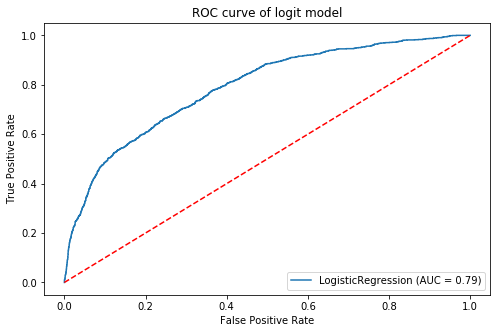

In [26]:
# Sklear offers an easy-to-use function to produce a ROC curve. 
metrics.plot_roc_curve(logit, X, y)
plt.title('ROC curve of logit model')
plt.plot([0, 1], [0, 1], "r--");  # the random benchmark we need to add manually

If you want a little more control, for example to depict the logit and tree model in one chart, you can proceed as follows: 

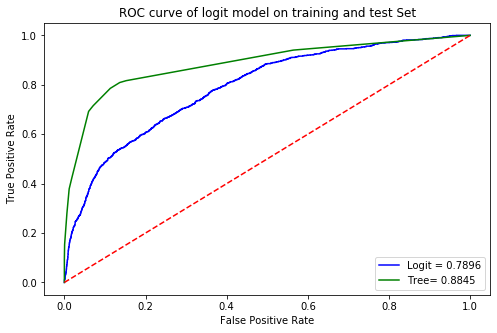

In [27]:
# Example how to 'manually' plot the ROC curve
fpr, tpr, _ = metrics.roc_curve(y, df_pred['p_logit'].values)  # extracting FPR and TPR for the logit model
fpr_tr, tpr_tr, _ = metrics.roc_curve(y, df_pred['p_tree'].values)  # same for the tree model

# Compute AUC
auc = metrics.auc(fpr, tpr) 
auc_tr = metrics.auc(fpr_tr, tpr_tr)

# ROC curve:
plt.plot(fpr, tpr, "b", label="Logit = %0.4f" % auc)
plt.plot(fpr_tr, tpr_tr, "b", label="Tree= %0.4f" % auc_tr, color='green')

# Random benchmark
plt.plot([0, 1], [0, 1], "r--");  

# Plot configuration
plt.title('ROC curve of logit model on training and test Set')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

### Brier score
Last but not least, the lecture introduced the *Brier score* as the mean-squared error of a zero-one encoded target variable and probabilistic model predictions. Let's see which of our models does better in terms of Brier score.

In [28]:
bs_logit = np.sum( (y - df_pred['p_logit'].values) **2) / len(y)
print("Brier score of logit: {:.4}".format(bs_logit))

bs_tree = np.sum( (y - df_pred['p_tree'].values) **2) / len(y)
print("Brier score of the tree: {:.4}".format(bs_tree))

Brier score of logit: 0.127
Brier score of the tree: 0.08425


The Brier score is an error measure. Lower values indicate better performance. So, we once again find the tree to do better. As a matter of fact, **it was almost certain that the tree would perform better.** Any ideas why this is the case? If yes, pad yourself on the shoulder. You have really understood what predictive modeling is about.

# Data partitioning and organization
Still searching for an answer to the above question why the tree was expected to beat logit? Want some help? The answer has to do with the data we used for calculating predictions and, by extension, model assessment. Specifically, we used the same data for model training and model evaluation. The lecture elaborates on why this is a bad idea, and our empirical results from the previous part kinda confirm that. Go back to the previous part and re-run the codes. This time, however, set the argument `max_depth` for the tree classifier to 10. What do you observe? 

Remember the golden rule of predictive modeling: **Always assess a model on fresh data**. To that end, our model evaluation pipelines routinely include sample splitting or cross-validation. 

##  Split sample approach

When building predictive models, our goal is to build unbiased, generalized models that perform well on any data. To be able to test the model on unknown data, we need to exclude a part of it when training the model. Splitting the data will give us a training and a test set. We use the training data to build the model, and the test data to validate our model performance. This is a common approach to avoid overfitting. It is quick and easy to implement.

There are various ways of splitting the data. Usually we randomly sample the data into training and test set at a predefined fraction. How much data we use for the training and test data depends on the amount of data we have. For instance, if our data is scarce, we might chose a higher fraction for the training data. As a rule of thumb: the more data we have for training, the better our model will be. Common approaches are to split the data at a ratio of 80:20 or 70:30.

We can implement the splitting manually or use predefined functions. We can implement it manually like this:

In [29]:
# Create random boolean array at a 70:30 ratio
np.random.seed(888)
split_sample = np.random.rand(len(df)) < 0.7 

# Use sample to create train and test set
X_train, y_train = df[split_sample].drop(['BAD'], axis=1), df[split_sample]['BAD']
X_test, y_test =  df[~split_sample].drop(['BAD'], axis=1), df[~split_sample]['BAD'] # use ~split_sample to select the opposite observations of split_sample

# Check shape 
print(X_train.shape, X_test.shape) 
print(y_train.shape, y_test.shape)

(4114, 18) (1846, 18)
(4114,) (1846,)


Model trained: LogisticRegression
The AUC on the test set of this model is: 0.7883

Model trained: DecisionTreeClassifier
The AUC on the test set of this model is: 0.8648



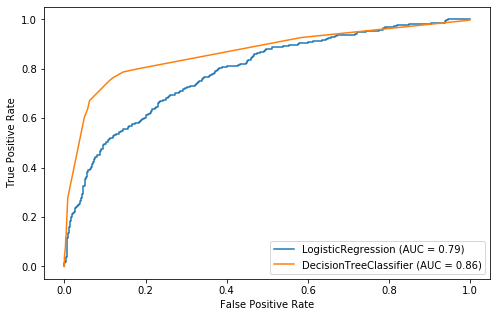

In [30]:
# Train a model and evaluate it using the split sample approach

# Create plot
fig, ax = plt.subplots()

# Create list of models for the loop
models = [logit, tree] 

# Loop to train and evaluate a model
for model in models: 
  print('Model trained: {}'.format(type(model).__name__))

  # Fit model using the training set
  model.fit(X_train, y_train) 

  # Make prediction using the test set
  temp = model.predict_proba(X_test)[:,1] 

  # Calcuate AUC score by using the prediction and y_test 
  print('The AUC on the test set of this model is: {:.4f}'.format(metrics.roc_auc_score(y_test, temp))) # use our predictions on the test set and compare them to their actuals, y_test 
  print('')

  # Plot ROC curve
  metrics.plot_roc_curve(model, X_test, y_test, ax=ax) 

As mentioned, this approach can help build generalizable, unbiased models and avoid overfitting. In the following code, we compare the ROC curves and AUC scores of the built models evaluated on the training set and test set. We expect the scores to be higher for the training set, as the models were built on this data.

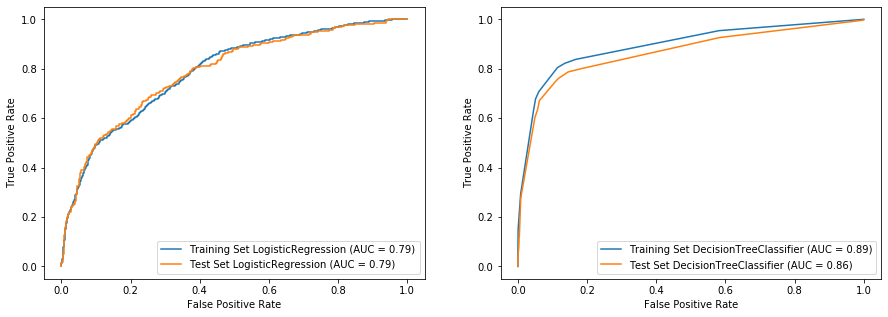

In [31]:
# Comparing predictions on train and test set

fig, ax = plt.subplots(figsize=(15,5))

for i, model in enumerate(models): 
  ax = plt.subplot(1, 2, i+1) # we can iterate the final number on the subplot to create different plots during the loop, cannot be 0
  metrics.plot_roc_curve(model, X_train, y_train, ax=ax, name= 'Training Set {}'.format(type(model).__name__))
  metrics.plot_roc_curve(model, X_test, y_test, ax=ax, name= 'Test Set {}'.format(type(model).__name__))

You can also split the data using existing functions. The most common function to use is `train_test_split()`, which splits the data into 4 variables.

In [32]:
from sklearn.model_selection import train_test_split

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)

# Check shape
print(X_train.shape, X_test.shape) 
print(y_train.shape, y_test.shape)

(4172, 18) (1788, 18)
(4172,) (1788,)


Lets train a: LogisticRegression
The AUC of ths model is: 0.7923

Lets train a: DecisionTreeClassifier
The AUC of ths model is: 0.8835



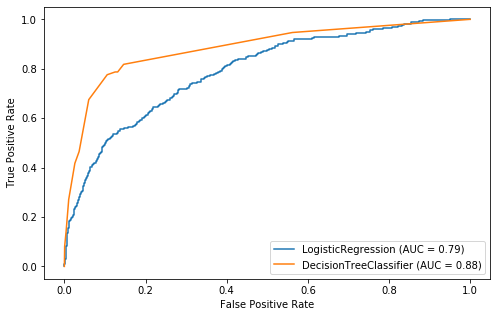

In [33]:
# Use this data as input for our loop for model building and evaluation of the split sample approach

fig, ax = plt.subplots()

for model in models: 
  print('Lets train a: {}'.format(type(model).__name__))
  model.fit(X_train, y_train)
  temp = model.predict_proba(X_test)[:,1]
  
  print('The AUC of ths model is: {:.4f}'.format(metrics.roc_auc_score(y_test, temp)))
  print('')
  metrics.plot_roc_curve(model, X_test, y_test, ax=ax)

## Cross-validation
Cross validation is an extended approach of the split sample method. It consists of repeating the split sample method multiple times.

Step by step:
- Randomly split data in N disjoint folds (E.g., N=5) 
- Build model on N-1 folds and validate that model on the remaining fold 
- Apply trained model to predict cases in the validation sample (hold-out data) 
- Measure model performance 
- Repeat N times and average 
- Average model performance over validation folds gives performance estimate 
- Can also estimate standard deviation (e.g., for statistical hypothesis testing)

It is an extension to the split sample approach, as we use all the data for model building, which can improve our model building and predictions.

### Cross-validation from scratch
As always, we start with examining how we can implement an algorithm, in this case cross-validation, manually without involving higher-level functions of, e.g., `skelarn`. Below is an example. The code makes use of some maybe more advanced features of Python indexing. Examine our custom function `cv_split()` and you see what we mean. This [threat on stackoverflow](https://stackoverflow.com/questions/9027862/what-does-listxy-do) offers useful background on the maybe strange looking index `i::splits`. In a nutshell, what we do is:
- We take a list (i.e., `seq` in the code)
- We index that list
  - starting from i
  - all the way to the end
  - with a **step size** of splits
  
The call of our customer function probably also warrants a little time to understand what it does. As always, play with codes and debug statements you do not understand right away. For example, 
- Print out the result of calling `df.index.values.tolist()`
- Next print out the result of `shuffle(df.index.values.tolist(), random_state = 888)`
- etc.

In [34]:
# Use shuffle function to make the split random
from sklearn.utils import shuffle

# Define number of splits
k = 5

# Create function splitting the data into k equal sets
def cv_split(seq, splits):
    return (seq[i::splits] for i in range(splits))  # The :: might look odd. Python's slicing syntax is quite powerful and we make use of it here. Check out this URL if you'd like to know the details or simply play with the code to debug 

# Create a list of the index of our full data set as input, and k for the amount of splits
cv_split_list = list(cv_split(shuffle(df.index.values.tolist(), random_state = 888), k)) 

In [ ]:
# Empty cell for your debuggin (hint, hint)




To further improve our understanding of the cross-validation from scratch example, let's loop over our folds and see whether they are of the right length.

In [34]:
# Check if they all are the correct length (length of whole dataframe / k)
for i, element in enumerate(cv_split_list):

    print('Fold {}'.format(i+1), 'is the correct lentgh = {}'.format(len(element)==int(len(df)/k))) #check if all elements are the correct size, which is the length of the total dataframe devided by how many subsets we want

Fold 1 is the correct lentgh = True
Fold 2 is the correct lentgh = True
Fold 3 is the correct lentgh = True
Fold 4 is the correct lentgh = True
Fold 5 is the correct lentgh = True


Ok that looks good. We now have defined $k$ folds each of which contains the same number of data points, whereby the order of the data points has previously been randomized by calling the function `shuffle()`. That completes the data splitting part of cross-validation. If you move up a bit in the notebook, you find the bullet list of cross-validation steps right after the section header. Out of that list, we have dealt with the first bullet. So not quite there yet. 

Next is the iterative part. Each of our data bucket serves as a validation sample once and we use that sample to assess a model, which we estimate from the union of the $k-1$ other buckets. That is what we do in the following piece of code. It looks quite long but actually introduces not much new materials. You know how to train a model and generate predictions. That is what we do, and since we apply cross-validation, we do it in a loop. Further, in each iteration of the loop, we create a ROC curve. This gives a nice graph in the end, which provides an easy to grasp idea how model performance varies over the cross-validation iterations (i.e., folds).

We will apply cross-validation for the following model: LogisticRegression

This is the 1. iteration
The AUC on test set is: 0.7729
Average AUC on test set during cross-validation: 0.7729

This is the 2. iteration
The AUC on test set is: 0.7800
Average AUC on test set during cross-validation: 0.7764

This is the 3. iteration
The AUC on test set is: 0.7987
Average AUC on test set during cross-validation: 0.7839

This is the 4. iteration
The AUC on test set is: 0.7785
Average AUC on test set during cross-validation: 0.7825

This is the 5. iteration
The AUC on test set is: 0.7942
The final average AUC is: 0.7849
The standard error is: 0.0099

We will apply cross-validation for the following model: DecisionTreeClassifier

This is the 1. iteration
The AUC on test set is: 0.7729
Average AUC on test set during cross-validation: 0.7938

This is the 2. iteration
The AUC on test set is: 0.7800
Average AUC on test set during cross-validation: 0.8026

This is the 3. iteration
The AUC on test set i

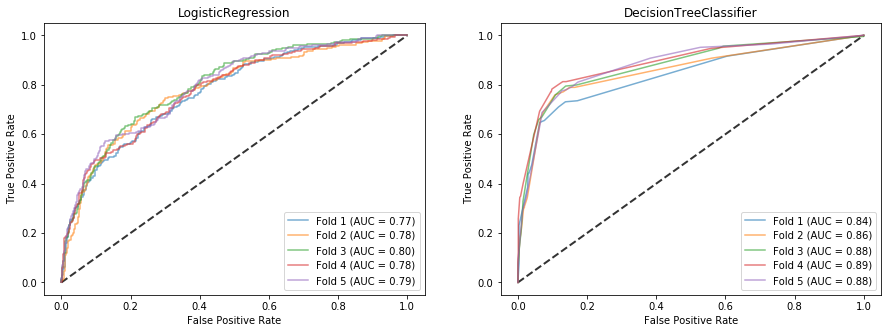

In [35]:
# Setting the figure size and setting a variable (x) to a random number, so we can create two seperate subplots
fig, ax = plt.subplots(figsize=(15,5))

# Lets define all the empty variables for our loop
cv_auc = []

# Loops through the model list
for x, model in enumerate(models):
  
  print('We will apply cross-validation for the following model: {}'.format(type(model).__name__))
  print('')

  # Setting subplot, title and creating the random benchmark line
  ax = plt.subplot(1,2, x+1) 
  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
  ax.set_title((type(model).__name__)) 
  x = x + 1 # add one so the next model will be plotted in a seperate plot

  # Start another loop for the cv_split_split, every model will go through this loop:
  for i, cv_split in enumerate(cv_split_list): # Enumerate: loop over an iterable with an automatic running index generated by a counter variable. The counter starts at 0 by default. This will be our variable i. 

    # Display iteration                                  
    iteration = i + 1 # +1 as it starts at 0                  
    print('This is the '+ str(iteration)+'. iteration')

    # Apply cv_split to the data frame, matches indeces in cv_split and the whole dataframe and creates a variable including the subset
    temp = df.index.isin(cv_split) # cv_split defines our hold out data for each round            
                                      
                                       
    # Split data using the temp variable, temp will be our test data                                         
    X_train, y_train = X.iloc[~temp], y[~temp] 
    X_test, y_test =  X.iloc[temp], y[temp]   

    # Fit model
    model.fit(X_train, y_train)                                                             

    # Use roc_plot_curve function to calculate fpr, tpr and compute the ROC curve for the current model                                 
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,  
                         name='Fold {}'.format(iteration),
                         alpha=0.6, ax=ax) 
    # Calculate AUC based on fpr and tpr emerging from the roc_plot_curve function
    cv_auc.append(metrics.auc(roc_plot.fpr, roc_plot.tpr)) 
    print('The AUC on test set is: {:.4f}'.format(cv_auc[i]))    

    # For the final iteration:
    if iteration == k: 

      # average over all AUCs that are stored up until the current iteration
      print('The final average AUC is: {:.4f}'.format(sum(cv_auc) / float(len(cv_auc))))  

      # Calculae standard error of AUC
      std_auc = np.std(cv_auc)
      print('The standard error is: {:.4f}'.format(std_auc))

    # For every other iteration 
    else:
      print('Average AUC on test set during cross-validation: {:.4f}'.format(sum(cv_auc) / float(len(cv_auc))))       #
                                                                             
    print('') 

plt.show()

As we know, usually there are functions already implementing what we need; same for cross-validation.

In [36]:
# cross_val_score function only incorporates one scoring measures
from sklearn.model_selection import cross_val_score                

# Create list so we can loop through scoring measures
scoring = ['neg_mean_absolute_error', 'roc_auc'] 
                   
for score in scoring:

   # Use cv=kf from above to integrate cross-validation, we use the full data (X and y) here, as the function will split the data for us
   temp = cross_val_score(logit, X, y, scoring= score, cv=k)   # set cv to k, the number of splits

   # Print scores and their average
   print('The {}'.format(score), 'scores are: {}'.format(temp))
   print('The mean {}'.format(score), 'is {}'.format(np.mean(temp))) 
   print('')

The neg_mean_absolute_error scores are: [-0.20889262 -0.1988255  -0.17533557 -0.1602349  -0.18204698]
The mean neg_mean_absolute_error is -0.18506711409395973

The roc_auc scores are: [0.76939644 0.76583778 0.76848035 0.80217747 0.73863521]
The mean roc_auc is 0.7689054502446673



In [37]:
# This is an extension to the above function, incorporates several scoring parameters
from sklearn.model_selection import cross_validate 

# Add list of scoring parameters directly to the function
score = cross_validate(logit, X, y, scoring=scoring, cv=k)
score

{'fit_time': array([0.02992153, 0.03291154, 0.03390956, 0.02593231, 0.03291202]),
 'score_time': array([0.00698113, 0.00398803, 0.00698185, 0.00498438, 0.00598478]),
 'test_neg_mean_absolute_error': array([-0.20889262, -0.1988255 , -0.17533557, -0.1602349 , -0.18204698]),
 'test_roc_auc': array([0.76939644, 0.76583778, 0.76848035, 0.80217747, 0.73863521])}

In [38]:
# Calculate mean values for the above function
pd.DataFrame(score).mean()

fit_time                        0.031117
score_time                      0.005784
test_neg_mean_absolute_error   -0.185067
test_roc_auc                    0.768905
dtype: float64

# Extras:
Here is a slightly more sophisticated version of our previous cross-validation from scratch example in which we also create an average ROC curve. This is a little extra for the experts. Feel free to ignore.

This is the 1. iteration
The AUC on test set  is:0.8030
Average AUC on test set during cross-validation:0.8030

This is the 2. iteration
The AUC on test set  is:0.7831
Average AUC on test set during cross-validation:0.7930

This is the 3. iteration
The AUC on test set  is:0.7536
Average AUC on test set during cross-validation:0.7799

This is the 4. iteration
The AUC on test set  is:0.8095
Average AUC on test set during cross-validation:0.7873

This is the 5. iteration
The AUC on test set  is:0.7716
Average AUC on test set during cross-validation:0.7842



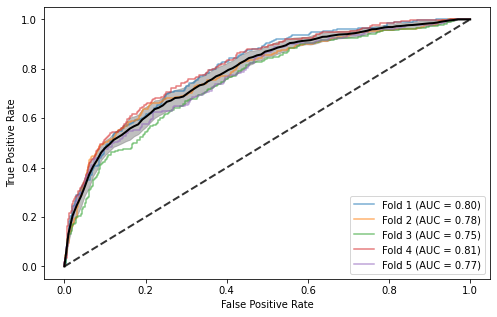

In [61]:
fig, ax = plt.subplots()

# Create empty variables 

mean_fpr = np.linspace(0, 1, 100) # Returns evenly spaced samples, calculated over the interval:  np.linespace(start, stop, number of samples)
tpr_list = []  
cv_auc = []

# Create loop as before
for i, cv_split in enumerate(cv_split_list): 
                                      
  iteration = i + 1                 
  print('This is the '+ str(iteration)+'. iteration')
  temp = df.index.isin(cv_split)            

  X_train, y_train = X.iloc[~temp], y[~temp] 
  X_test, y_test =  X.iloc[temp], y[temp]    
  

  logit.fit(X_train, y_train)                                                             
  temp_pred = logit.predict_proba(X_test)[:, 1]                                            
  
  roc_plot = metrics.plot_roc_curve(logit, X_test, y_test,  
                         name='Fold {}'.format(iteration),
                         alpha=0.6, ax=ax) 
  cv_auc.append(metrics.auc(roc_plot.fpr, roc_plot.tpr)) 
  print('The AUC on test set  is:{:.4f}'.format(cv_auc[i]))                                                            
  print('Average AUC on test set during cross-validation:{:.4f}'.format(sum(cv_auc) / float(len(cv_auc))))
  
  # Linear interpolation, fitting a curve using the discrete coordinates
  interp_tpr = np.interp(mean_fpr, roc_plot.fpr, roc_plot.tpr)
  interp_tpr[0] = 0.0
  tpr_list.append(interp_tpr)                                                                                                           
  print('')                         
                                    
# Calculate values for mean ROC curve
mean_tpr = np.mean(tpr_list, axis=0) 
mean_tpr[-1] = 1.0                       
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(cv_auc)
std_tpr = np.std(tpr_list, axis=0)   
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

# Plot curves
ax.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=.5,
                label=r'$\pm$ 1 std. dev.')

ax.plot(mean_fpr, mean_tpr, color='k',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=1)


# Random benchmark
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)

plt.show()